# EDA

In [1]:
%matplotlib inline


# Essential libraries
import os
import numpy as np
import pandas as pd
import math
import scipy
import random
import datetime
from datetime import datetime, timedelta
from pathlib import Path

# Graphical Component
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import seaborn as sns

# SQL Component
from urllib.request import urlretrieve
import sqlite3

# Pipeline and Train Test Split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


## SciKit Learning Preprocessing  
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## SciKit Learn ML Models
from sklearn.linear_model import Lasso, LogisticRegression


## Data Download

In [2]:
data_path = Path('./src/data')
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print(f'Data folder not exists. Create folder')


url = 'https://techassessment.blob.core.windows.net/aiap-pys-2/noshow.db'

file_path = Path('./src/data/noshow.db')

if file_path.exists():
    print('File already exist, skip download.')
else:
    try:
        print('Downloading Data File')
        urlretrieve(url, file_path)
        print('Download completed')
    except:
        print("Error downloading file. Please check if the file exist at the location:", url)
        print("Please also check if Internet connection is present.")



File already exist, skip download.


## Import Data to DataFrame

In [3]:
list_all_tables = "SELECT name FROM sqlite_master WHERE type='table';"

conn = sqlite3.connect(file_path)
cur = conn.cursor()
cur.execute(list_all_tables)
tables_all = cur.fetchall()[0]
tables_all = list(tables_all)
print(tables_all)
conn.close()

['noshow']


In [4]:
read_table = 'SELECT * FROM ' + tables_all[0]
print(read_table)

SELECT * FROM noshow


In [5]:
conn = sqlite3.connect('./src/data/noshow.db')
df = pd.read_sql(read_table, conn)
conn.close()

## Display Dataframe and Basic Information

In [6]:
df

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
119387,25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
119388,81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0
119389,6738,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,SGD$ 886.35,Website,2,0.0


In [7]:
m = len(df)
print(f"There are a total of {m} records.")

There are a total of 119391 records.


#### Display Basic Information

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   booking_id      119391 non-null  int64  
 1   no_show         119390 non-null  float64
 2   branch          119390 non-null  object 
 3   booking_month   119390 non-null  object 
 4   arrival_month   119390 non-null  object 
 5   arrival_day     119390 non-null  float64
 6   checkout_month  119390 non-null  object 
 7   checkout_day    119390 non-null  float64
 8   country         119390 non-null  object 
 9   first_time      119390 non-null  object 
 10  room            97778 non-null   object 
 11  price           94509 non-null   object 
 12  platform        119390 non-null  object 
 13  num_adults      119390 non-null  object 
 14  num_children    119390 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 13.7+ MB


In [9]:
df.info

<bound method DataFrame.info of         booking_id  no_show   branch booking_month arrival_month  arrival_day  \
0            94113      0.0   Changi      November          June         25.0   
1            86543      0.0  Orchard        August      November         28.0   
2            75928      0.0   Changi         March      February          7.0   
3            66947      1.0  Orchard     September       October          1.0   
4           106390      0.0  Orchard         March          June         20.0   
...            ...      ...      ...           ...           ...          ...   
119386        4823      0.0   Changi     September         April          3.0   
119387       25062      0.0  Orchard         March      December         30.0   
119388       81936      1.0   Changi     September         March         31.0   
119389        6738      0.0   Changi      February      February         25.0   
119390       99643      0.0   Changi         March          July         18.0

<font color='blue'>
    
**Identified column `no_show` as target. Assume 1 as customer did not show up. Need to confirm with the management.**
    
**Identified column `price` that needs further processing. We need to extract the currency and convert all prices to same local currency.**

In [10]:
df.branch.unique()

array(['Changi', 'Orchard', None], dtype=object)

In [11]:
df.num_adults.unique()

array(['1', '2', 'one', 'two', None], dtype=object)

<font color='blue'>
    
**Identified column `num_adults` is in string. Need to convert to integer. Also need to check for `None` value.**

In [12]:
df.describe()

,booking_id,no_show,arrival_day,checkout_day,num_children
count,119391.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59695.000000,0.370416,15.798241,14.250507,0.871229
std,34465.357332,0.482918,8.780829,11.063697,0.779796
min,0.000000,0.000000,1.000000,-31.000000,0.000000
25%,29847.500000,0.000000,8.000000,7.000000,0.000000
50%,59695.000000,0.000000,16.000000,15.000000,1.000000
75%,89542.500000,1.000000,23.000000,23.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,3.000000


In [13]:
df.isnull().sum()

booking_id            0
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64

<font color='blue'>

**We need to address the null values for the column `room` and the column `price` which part of the features. We also need to check for record which has multiple null.**

#### Checking `booking_id`

**There is a column known as `student_id` which potentially can be used as index.**

In [14]:
len(df['booking_id'].unique())

119391

<font color = 'blue'>

**The booking_id is unique. This can be used as index.**

#### Checking for record with multiple null entries

In [15]:
df[df['no_show'].isnull()]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
111598,115536,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None,None,NaN


<font color='blue'>

**This record can be deleted.**

#### Checking Categorical Columns

In [16]:
df.info

<bound method DataFrame.info of         booking_id  no_show   branch booking_month arrival_month  arrival_day  \
0            94113      0.0   Changi      November          June         25.0   
1            86543      0.0  Orchard        August      November         28.0   
2            75928      0.0   Changi         March      February          7.0   
3            66947      1.0  Orchard     September       October          1.0   
4           106390      0.0  Orchard         March          June         20.0   
...            ...      ...      ...           ...           ...          ...   
119386        4823      0.0   Changi     September         April          3.0   
119387       25062      0.0  Orchard         March      December         30.0   
119388       81936      1.0   Changi     September         March         31.0   
119389        6738      0.0   Changi      February      February         25.0   
119390       99643      0.0   Changi         March          July         18.0

<font color='blue'>
    
**Identified categorical features are `branch`, `booking_month`, `country`, `room`, `first_time`, `arrival_month`, `checkout_month` and `platform`.**

**We can also engineered a new feature called `days_stayed `to check if the stay duration impacted no show occurrence. In addition we can also convert `booking_month` into `mths_adv_booking` to record number of months in advance booking before the arrival month.**

In [17]:
df['arrival_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December', 'ApRiL',
       'OcTobeR', 'JuNe', 'JulY', 'ApriL', 'OctOber', 'DecembEr',
       'SeptEmber', 'JanUary', 'JUne', 'FeBruary', 'JanuarY', 'DEcember',
       'SePtember', 'DecembeR', 'MaY', 'NoVember', 'JUly', 'JunE', 'JuLy',
       'FebrUary', 'NOvember', 'SeptemBer', 'OctobeR', 'DecemBer',
       'MarCh', 'AuguSt', 'AugusT', 'APril', 'SepTember', 'NovembEr',
       'FEbruary', 'DeceMber', 'AuGust', 'SepteMber', 'FebruaRy',
       'OctoBer', 'JanuaRy', 'MarcH', 'ApRil', 'AUgust', 'JanuAry',
       'NOveMber', 'MaRch', 'AprIl', 'MAy', 'NovemBer', 'DecEmber',
       'MArch', 'JaNuary', 'NovembeR', 'SeptembEr', 'FebruarY',
       'SeptembeR', 'OcTober', 'DeCember', 'FebruAry', 'AugUst',
       'NovEmber', 'NoveMber', 'OctobEr', 'OCtober', 'SEptember',
       'JAnuary', 'SeptEMber', 'MAY', 'FebRuary', 'FeBruarY', 'OCTober',
       'JUnE', 'DecEMber', 'Febru

In [18]:
df['arrival_day'].unique()

array([25., 28.,  7.,  1., 20., 12., 15., 18., 27., 22.,  9., 11., 10.,
       13., 30., 21.,  5.,  6.,  2., 31., 19.,  4.,  3., 23., 17.,  8.,
       26., 14., 24., 29., 16., nan])

In [19]:
df['checkout_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December', None],
      dtype=object)

In [20]:
df['checkout_day'].unique()

array([ 27.,  29.,  11.,   3.,  24.,  13.,  16.,  19.,  28.,  10.,  12.,
        15.,  23.,  31.,  25.,  17.,   8.,   2.,   9.,   7.,   1.,  20.,
        14.,  -4.,   4.,   6.,  21.,   5.,  18.,  22., -10.,  -3.,  30.,
        26.,  -6.,  -5., -28., -20., -16., -19., -17., -12., -30., -26.,
        -8., -24., -15., -21.,  -1.,  -7., -27., -11., -18., -22., -13.,
       -14., -29., -23.,  -9.,  -2., -31., -25.,  nan])

<font color='blue'>
    
**For `arrival_month`, we need to fixed the uppercase and lowercase issue. For `checkout_day`, we need to fixed the negatives**

In [21]:
df.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


### Basic Analysis Summary

Base on the information above, we need to consider the following:

- The target `y_train` should be the `no_show` column. Need to confirm with management that customer who did not show up is 1.
- The column `booking_id` can be use as index.
- We need to remove one null record with `booking_id = 115536`.
- We need to change `num_adults` to integer and check for null values.
- Also change `no_show` and `num_children` to integer.
- We need to process the column `price` by extracting the currency and convert the price to local currency.
- We need to fill up the null values for `room` and `price`.
- For room type we use the most frequent room in the existing data.
- As price is seasonal, we will use the average price of same day and room type to fill the null value. If there is no price, then we use the average price of the room type.
- We also need to fixed the uppercase and lowercase issue in `arrival_month`.
- For `checkout_day`, we also need to fixed the negative number.
- We can also add a new column to compute the number of days stayed column name is `days_stayed`.
- We can create a new column known as `mths_adv_booking`, to record the number of months with advance booking.
- Categorical features such as `branch`, `country`, `room` and `platform`, should be converted into one-hot encoding for machine learning. We can serialized the date for `booking_month`, `arrival_month` and `checkout_month`. For EDA analysis, we will be using class index encoder.
- We will use correlational analysis to check for close correlation.
- We also need to check for imbalance data size.

### Plan of Action

We also plan for the following actions:
1. We need to set the index using `booking_id`.
2. We need to remove one record with null values in `booking_id = 115536`.
3. Change `num_adults` to integer and investigate the null values.
4. Change `no_show` and `num_children` to integer.
5. Extract the currency from `price` column and convert the `price` of other currency to local currency and set the new column `local_price` as float.
6. Fixed the `arrival_month` and `checkout_day` issue.
7. Compute a new column `days_stayed` by taking the difference between arrival day and checkout day.
8. Create a new column `mths_adv_booking` to record number of months of advance booking. This is to check if there is any information against no show.
9. Perform data splitting to train and test data.
10. Find out the most frequent room type and fill the null value of column `room` with the most frequent room type.
11. For null values on column `price`, we will use same month, same day, same branch and same room type as the average price reference. If no reference available, then we use average price of same month, same branch and same room type. We will further reduce to same month and same room type if there are still null values.
12. For EDA we convert all categorical data into class index for analysis. For machine learning, we will perform one-hot encoding for `branch`, `country`, `room`, `first_time` and `platform`. We will use own mapping for months.
13. Use correlational analysis to check which features has the least correlation. Also applied Lasso regression to see what features are important.
14. Check if `y` label is imbalance.

### Important Assumption

- In the target label `no_show`, `1` is customer did not show up.
- Currency conversion rate of 1 USD is 1.35.

In [22]:
SGD_one_USD = 1.35 

## Data Cleaning Before Data Split

In [23]:
df.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


### 1. Setting Index

In [24]:
df.pivot_table(index=['booking_id'], aggfunc='size')

booking_id
0         1
1         1
2         1
3         1
4         1
         ..
119386    1
119387    1
119388    1
119389    1
119390    1
Length: 119391, dtype: int64

<font color='red'>

**`booking_id` is unique. Use `booking_id` as index.**

In [25]:
df.set_index('booking_id', inplace=True)

In [26]:
df

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
booking_id,,,,,,,,,,,,,,
94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0


In [27]:
m = len(df)
print(f"There are a total of {m} records.")

There are a total of 119391 records.


### 2. Checking and Removing Null Record

In [28]:
df[df['no_show'].isnull()]

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
booking_id,,,,,,,,,,,,,,
115536,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None,None,NaN


<font color='red'>

**Delete record with index 115536 or set condition when no_show is null.**

In [29]:
df = df.drop(df[df['no_show'].isnull()].index)

In [30]:
m = len(df)
print(f"There are a total of {m} records.")

There are a total of 119390 records.


In [31]:
df.isnull().sum()

no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room              21612
price             24881
platform              0
num_adults            0
num_children          0
dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 94113 to 99643
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   no_show         119390 non-null  float64
 1   branch          119390 non-null  object 
 2   booking_month   119390 non-null  object 
 3   arrival_month   119390 non-null  object 
 4   arrival_day     119390 non-null  float64
 5   checkout_month  119390 non-null  object 
 6   checkout_day    119390 non-null  float64
 7   country         119390 non-null  object 
 8   first_time      119390 non-null  object 
 9   room            97778 non-null   object 
 10  price           94509 non-null   object 
 11  platform        119390 non-null  object 
 12  num_adults      119390 non-null  object 
 13  num_children    119390 non-null  float64
dtypes: float64(4), object(10)
memory usage: 13.7+ MB


### 3. Convert Column `num_adults`

In [33]:
df.num_adults.unique()

array(['1', '2', 'one', 'two'], dtype=object)

<font color='red'>

**Replace string `one` with `1` and `two` with `2`, before converting all strings to integer.**

In [34]:
df.num_adults = df.num_adults.replace('one', '1')
df.num_adults = df.num_adults.replace('two', '2')

In [35]:
df.num_adults.unique()

array(['1', '2'], dtype=object)

<font color='red'>

**Convert column to integer.**

In [36]:
df.num_adults = df.num_adults.astype(int)

In [37]:
df.num_adults.unique()

array([1, 2])

### 4. Change `no_show` and `num_children` to Integer.

<font color='red'>

**Convert column to integer.**

In [38]:
df.num_children = df.num_children.astype(int)
df.no_show = df.no_show.astype(int)

In [39]:
df.num_children.unique()

array([0, 2, 1, 3])

In [40]:
df.no_show.unique()

array([0, 1])

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 94113 to 99643
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   no_show         119390 non-null  int64  
 1   branch          119390 non-null  object 
 2   booking_month   119390 non-null  object 
 3   arrival_month   119390 non-null  object 
 4   arrival_day     119390 non-null  float64
 5   checkout_month  119390 non-null  object 
 6   checkout_day    119390 non-null  float64
 7   country         119390 non-null  object 
 8   first_time      119390 non-null  object 
 9   room            97778 non-null   object 
 10  price           94509 non-null   object 
 11  platform        119390 non-null  object 
 12  num_adults      119390 non-null  int64  
 13  num_children    119390 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 13.7+ MB


### 5. Price Conversion

In [42]:
price_df = df['price'].str.split(' ', expand = True).copy()

In [43]:
price_df.columns = ['CUR', 'price']

In [44]:
price_df['CUR'].unique()

array(['SGD$', None, 'USD$'], dtype=object)

In [45]:
price_df.head()

,CUR,price
booking_id,,
94113,SGD$,492.98
86543,SGD$,1351.22
75928,None,None
66947,SGD$,666.04
106390,USD$,665.37


In [46]:
price_df.price

booking_id
94113      492.98
86543     1351.22
75928        None
66947      666.04
106390     665.37
           ...   
4823       612.18
25062     1041.29
81936      641.47
6738       886.35
99643      901.95
Name: price, Length: 119390, dtype: object

<font color='red'>

**Price is still in string, need to convert to floating point numbers.**

In [47]:
price_df.price = price_df.price.astype(float)

In [48]:
price_df.head()

,CUR,price
booking_id,,
94113,SGD$,492.98
86543,SGD$,1351.22
75928,None,NaN
66947,SGD$,666.04
106390,USD$,665.37


<font color='red'>

**Convert price in USD to SGD. Assumption 1 USD = 1.35 SGD**

In [49]:
price_df['local_price'] = price_df['price'].where(price_df.CUR != 'USD$', price_df.price * SGD_one_USD)

In [50]:
price_df[price_df['CUR'] == "USD$"]

,CUR,price,local_price
booking_id,,,
106390,USD$,665.37,898.2495
109456,USD$,658.75,889.3125
31117,USD$,962.75,1299.7125
88243,USD$,587.03,792.4905
3158,USD$,1056.70,1426.5450
...,...,...,...
62259,USD$,720.78,973.0530
108339,USD$,605.91,817.9785
4823,USD$,612.18,826.4430


In [51]:
price_df.head()

,CUR,price,local_price
booking_id,,,
94113,SGD$,492.98,492.9800
86543,SGD$,1351.22,1351.2200
75928,None,NaN,NaN
66947,SGD$,666.04,666.0400
106390,USD$,665.37,898.2495


<font color='red'>

**Merging price column to the main dataset and drop the old column.**

In [52]:
df2 = pd.merge(df, price_df['local_price'], left_index=True, right_index=True)

In [53]:
df2.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,local_price
booking_id,,,,,,,,,,,,,,,
94113,0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0,492.9800
86543,0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0,1351.2200
75928,0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0,NaN
66947,1,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0,666.0400
106390,0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0,898.2495


In [54]:
df2.drop(columns=['price'], inplace=True)

In [55]:
df2.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price
booking_id,,,,,,,,,,,,,,
94113,0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,Website,1,0,492.9800
86543,0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,Website,2,0,1351.2200
75928,0,Changi,March,February,7.0,February,11.0,India,Yes,Single,Agent,1,0,NaN
66947,1,Orchard,September,October,1.0,October,3.0,China,Yes,Single,Website,1,0,666.0400
106390,0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,Website,1,0,898.2495


### 6. Fixing `arrival_month` and `checkout_day` Issue

In [56]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 94113 to 99643
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   no_show         119390 non-null  int64  
 1   branch          119390 non-null  object 
 2   booking_month   119390 non-null  object 
 3   arrival_month   119390 non-null  object 
 4   arrival_day     119390 non-null  float64
 5   checkout_month  119390 non-null  object 
 6   checkout_day    119390 non-null  float64
 7   country         119390 non-null  object 
 8   first_time      119390 non-null  object 
 9   room            97778 non-null   object 
 10  platform        119390 non-null  object 
 11  num_adults      119390 non-null  int64  
 12  num_children    119390 non-null  int64  
 13  local_price     94509 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 17.7+ MB


**Day is on float and month is in string object.**

In [57]:
df2.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price
booking_id,,,,,,,,,,,,,,
94113,0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,Website,1,0,492.9800
86543,0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,Website,2,0,1351.2200
75928,0,Changi,March,February,7.0,February,11.0,India,Yes,Single,Agent,1,0,NaN
66947,1,Orchard,September,October,1.0,October,3.0,China,Yes,Single,Website,1,0,666.0400
106390,0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,Website,1,0,898.2495


In [58]:
df2['arrival_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December', 'ApRiL',
       'OcTobeR', 'JuNe', 'JulY', 'ApriL', 'OctOber', 'DecembEr',
       'SeptEmber', 'JanUary', 'JUne', 'FeBruary', 'JanuarY', 'DEcember',
       'SePtember', 'DecembeR', 'MaY', 'NoVember', 'JUly', 'JunE', 'JuLy',
       'FebrUary', 'NOvember', 'SeptemBer', 'OctobeR', 'DecemBer',
       'MarCh', 'AuguSt', 'AugusT', 'APril', 'SepTember', 'NovembEr',
       'FEbruary', 'DeceMber', 'AuGust', 'SepteMber', 'FebruaRy',
       'OctoBer', 'JanuaRy', 'MarcH', 'ApRil', 'AUgust', 'JanuAry',
       'NOveMber', 'MaRch', 'AprIl', 'MAy', 'NovemBer', 'DecEmber',
       'MArch', 'JaNuary', 'NovembeR', 'SeptembEr', 'FebruarY',
       'SeptembeR', 'OcTober', 'DeCember', 'FebruAry', 'AugUst',
       'NovEmber', 'NoveMber', 'OctobEr', 'OCtober', 'SEptember',
       'JAnuary', 'SeptEMber', 'MAY', 'FebRuary', 'FeBruarY', 'OCTober',
       'JUnE', 'DecEMber', 'Febru

<font color='red'>

**Convert all the string case to capitalized for `arrival_month`.**

In [59]:
df2['arrival_month'] = df2['arrival_month'].str.capitalize()

In [60]:
df2['arrival_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December'],
      dtype=object)

In [61]:
len(df2['arrival_month'].unique())

12

In [62]:
df2['checkout_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December'],
      dtype=object)

In [63]:
len(df2['checkout_month'].unique())

12

In [64]:
df2['checkout_day'].unique()

array([ 27.,  29.,  11.,   3.,  24.,  13.,  16.,  19.,  28.,  10.,  12.,
        15.,  23.,  31.,  25.,  17.,   8.,   2.,   9.,   7.,   1.,  20.,
        14.,  -4.,   4.,   6.,  21.,   5.,  18.,  22., -10.,  -3.,  30.,
        26.,  -6.,  -5., -28., -20., -16., -19., -17., -12., -30., -26.,
        -8., -24., -15., -21.,  -1.,  -7., -27., -11., -18., -22., -13.,
       -14., -29., -23.,  -9.,  -2., -31., -25.])

<font color='red'>

**Convert `checkout_day` to absolute value and convert to integer.**

In [65]:
df2['checkout_day'] = abs(df2['checkout_day']).astype(int)

In [66]:
df2['checkout_day'].unique()

array([27, 29, 11,  3, 24, 13, 16, 19, 28, 10, 12, 15, 23, 31, 25, 17,  8,
        2,  9,  7,  1, 20, 14,  4,  6, 21,  5, 18, 22, 30, 26])

In [67]:
len(df2['checkout_day'].unique())

31

<font color='red'>

**Convert `arrival_day` to integer.**

In [68]:
df2['arrival_day'] = df2['arrival_day'].astype(int)

In [69]:
df2['arrival_day'].unique()

array([25, 28,  7,  1, 20, 12, 15, 18, 27, 22,  9, 11, 10, 13, 30, 21,  5,
        6,  2, 31, 19,  4,  3, 23, 17,  8, 26, 14, 24, 29, 16])

In [70]:
len(df2['arrival_day'].unique())

31

### 7. Feature Engineering : Duration of Stay

In [71]:
date_df = df2[['booking_month', 'arrival_month', 'arrival_day', 'checkout_month', 'checkout_day']].copy()

In [72]:
date_df.head()

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day
booking_id,,,,,
94113,November,June,25,June,27
86543,August,November,28,November,29
75928,March,February,7,February,11
66947,September,October,1,October,3
106390,March,June,20,June,24


<font color='blue'>

**Checking for day that are wrong in short months.**

In [73]:
short_months = ['April', 'June', 'September', 'November']

In [74]:
for month in short_months:
    print(month)
    print(date_df[(date_df['arrival_month']==month) & (date_df['arrival_day'] == 31)])    

April
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []
June
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []
September
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []
November
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []


In [75]:
for month in short_months:
    print(month)
    print(date_df[(date_df['checkout_month']==month) & (date_df['checkout_day'] == 31)])   

April
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []
June
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []
September
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []
November
Empty DataFrame
Columns: [booking_month, arrival_month, arrival_day, checkout_month, checkout_day]
Index: []


<font color='blue'>
    
**No wrong days. Next, we check for 29 February.**

In [76]:
date_df[(date_df['arrival_month']=='February') & (date_df['arrival_day'] == 29)]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day
booking_id,,,,,
4663,May,February,29,March,2
80461,May,February,29,March,2
93563,May,February,29,March,2
24163,May,February,29,March,2
95194,December,February,29,March,2
...,...,...,...,...,...
92632,May,February,29,March,2
96768,May,February,29,March,2
22440,May,February,29,March,2


In [77]:
date_df[(date_df['checkout_month']=='February') & (date_df['checkout_day'] == 29)]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day
booking_id,,,,,


<font color='blue'>
    
**There is 29 in February, so this is a leap year. So we can set the year as a leap year. The year could also be 2016 or 2020. We set a dummy year in order to compute number of days stayed. For check out day there is no 29 Feb.**

<font color='red'>
    
**Create a new column as year and then combine `arrival_month` and `arrival_day` into datetime format as `start_date` for computation. Do the same for `checkout_month` and `checkout_day` with a new column `end_date`.**

In [78]:
date_df['year']= '2020' #2020 is a leap year

In [79]:
date_df.head()

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year
booking_id,,,,,,
94113,November,June,25,June,27,2020
86543,August,November,28,November,29,2020
75928,March,February,7,February,11,2020
66947,September,October,1,October,3,2020
106390,March,June,20,June,24,2020


In [80]:
date_df['start_date'] = pd.to_datetime(date_df['arrival_day'].astype(str)+'-'+date_df['arrival_month']+'-'+date_df['year'], format='%d-%B-%Y')
date_df['end_date'] = pd.to_datetime(date_df['checkout_day'].astype(str)+'-'+date_df['checkout_month']+'-'+date_df['year'], format='%d-%B-%Y')

<font color='blue'>
    
**We need to consider year end crossing over year to next year. Need to check if start date is larger then end date.**

In [81]:
date_df[date_df['start_date'] > date_df['end_date']]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date
booking_id,,,,,,,,
69075,August,December,31,January,1,2020,2020-12-31,2020-01-01
33099,June,December,31,January,2,2020,2020-12-31,2020-01-02
89915,April,December,29,January,2,2020,2020-12-29,2020-01-02
55261,January,December,29,January,1,2020,2020-12-29,2020-01-01
29180,July,December,29,January,2,2020,2020-12-29,2020-01-02
...,...,...,...,...,...,...,...,...
97916,August,December,30,January,1,2020,2020-12-30,2020-01-01
100380,November,December,30,January,3,2020,2020-12-30,2020-01-03
111510,October,December,31,January,2,2020,2020-12-31,2020-01-02


In [82]:
problem_year_list = (date_df[date_df['start_date'] > date_df['end_date']]).index

<font color='red'>
    
**Change the `end_date` to one year later, if the `start_date` is larger than end_date. For example, 30 December is greater than 3 January. So we add 1 year so that it will become 3 January on the next year.**

In [83]:
date_df['end_date'] = date_df['end_date'].where(date_df['start_date'] < date_df['end_date'], date_df['end_date'] + pd.DateOffset(years=1))

In [84]:
date_df[date_df['start_date'] > date_df['end_date']]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date
booking_id,,,,,,,,


In [85]:
date_df.loc[problem_year_list]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date
booking_id,,,,,,,,
69075,August,December,31,January,1,2020,2020-12-31,2021-01-01
33099,June,December,31,January,2,2020,2020-12-31,2021-01-02
89915,April,December,29,January,2,2020,2020-12-29,2021-01-02
55261,January,December,29,January,1,2020,2020-12-29,2021-01-01
29180,July,December,29,January,2,2020,2020-12-29,2021-01-02
...,...,...,...,...,...,...,...,...
97916,August,December,30,January,1,2020,2020-12-30,2021-01-01
100380,November,December,30,January,3,2020,2020-12-30,2021-01-03
111510,October,December,31,January,2,2020,2020-12-31,2021-01-02


<font color='red'>
    
**Compute a new column `days_stayed` by taking the difference between `start_date` and `end_date`.**

In [86]:
date_df['days_stayed'] = (date_df['end_date'] - date_df['start_date']).dt.days

In [87]:
date_df.head()

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date,days_stayed
booking_id,,,,,,,,,
94113,November,June,25,June,27,2020,2020-06-25,2020-06-27,2
86543,August,November,28,November,29,2020,2020-11-28,2020-11-29,1
75928,March,February,7,February,11,2020,2020-02-07,2020-02-11,4
66947,September,October,1,October,3,2020,2020-10-01,2020-10-03,2
106390,March,June,20,June,24,2020,2020-06-20,2020-06-24,4


In [88]:
date_df['days_stayed'].unique()

array([ 2,  1,  4, 14,  3,  5,  8, 28, 22, 15, 21, 29, 23, 40, 42, 49, 44,
        9, 35, 54, 62, 64, 43, 30,  6, 46, 16, 57])

In [89]:
date_df[date_df['days_stayed'] > 30]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date,days_stayed
booking_id,,,,,,,,,
17942,March,January,26,March,6,2020,2020-01-26,2020-03-06,40
75124,November,January,12,February,23,2020,2020-01-12,2020-02-23,42
66290,November,March,11,April,29,2020,2020-03-11,2020-04-29,49
108787,January,February,3,March,18,2020,2020-02-03,2020-03-18,44
62165,October,January,15,February,19,2020,2020-01-15,2020-02-19,35
25712,March,January,10,March,4,2020,2020-01-10,2020-03-04,54
72708,March,August,1,October,2,2020,2020-08-01,2020-10-02,62
37081,January,July,5,September,7,2020,2020-07-05,2020-09-07,64
5623,October,January,15,February,19,2020,2020-01-15,2020-02-19,35


**There is only a handful of visitor stayed longer than 30 days.**

In [90]:
date_df.loc[problem_year_list]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date,days_stayed
booking_id,,,,,,,,,
69075,August,December,31,January,1,2020,2020-12-31,2021-01-01,1
33099,June,December,31,January,2,2020,2020-12-31,2021-01-02,2
89915,April,December,29,January,2,2020,2020-12-29,2021-01-02,4
55261,January,December,29,January,1,2020,2020-12-29,2021-01-01,3
29180,July,December,29,January,2,2020,2020-12-29,2021-01-02,4
...,...,...,...,...,...,...,...,...,...
97916,August,December,30,January,1,2020,2020-12-30,2021-01-01,2
100380,November,December,30,January,3,2020,2020-12-30,2021-01-03,4
111510,October,December,31,January,2,2020,2020-12-31,2021-01-02,2


<font color='red'>

**Merging the the column `days_stayed` to the main datasets.**

In [91]:
df3 = pd.merge(df2, date_df['days_stayed'], left_index=True, right_index=True)

In [92]:
df3.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed
booking_id,,,,,,,,,,,,,,,
94113,0,Changi,November,June,25,June,27,Singapore,Yes,Single,Website,1,0,492.9800,2
86543,0,Orchard,August,November,28,November,29,Indonesia,Yes,King,Website,2,0,1351.2200,1
75928,0,Changi,March,February,7,February,11,India,Yes,Single,Agent,1,0,NaN,4
66947,1,Orchard,September,October,1,October,3,China,Yes,Single,Website,1,0,666.0400,2
106390,0,Orchard,March,June,20,June,24,Australia,Yes,Queen,Website,1,0,898.2495,4


In [93]:
df3[df3.days_stayed > 30]

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed
booking_id,,,,,,,,,,,,,,,
17942,0,Orchard,March,January,26,March,6,Australia,Yes,Single,Website,1,0,683.9900,40
75124,1,Orchard,November,January,12,February,23,China,Yes,King,Website,2,2,1434.9420,42
66290,0,Changi,November,March,11,April,29,China,Yes,King,Website,2,1,868.8060,49
108787,0,Orchard,January,February,3,March,18,Australia,No,King,Phone,2,2,NaN,44
62165,1,Changi,October,January,15,February,19,Indonesia,Yes,King,Agent,1,1,943.8930,35
25712,1,Orchard,March,January,10,March,4,China,Yes,None,Email,2,1,1232.3880,54
72708,0,Orchard,March,August,1,October,2,Indonesia,Yes,Queen,Website,1,0,1102.1000,62
37081,0,Orchard,January,July,5,September,7,Indonesia,Yes,Queen,Agent,1,1,NaN,64
5623,1,Changi,October,January,15,February,19,Indonesia,Yes,Single,Website,1,1,517.5200,35


### 8. Feature Engineering: Number of Months of Advance Booking

In [94]:
date_df.head()

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date,days_stayed
booking_id,,,,,,,,,
94113,November,June,25,June,27,2020,2020-06-25,2020-06-27,2
86543,August,November,28,November,29,2020,2020-11-28,2020-11-29,1
75928,March,February,7,February,11,2020,2020-02-07,2020-02-11,4
66947,September,October,1,October,3,2020,2020-10-01,2020-10-03,2
106390,March,June,20,June,24,2020,2020-06-20,2020-06-24,4


In [97]:
# Filter out booking month that is later than arrival month
date_df[date_df['start_date'].dt.month < pd.to_datetime(date_df['booking_month'], format='%B').dt.month]

,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,year,start_date,end_date,days_stayed
booking_id,,,,,,,,,
94113,November,June,25,June,27,2020,2020-06-25,2020-06-27,2
75928,March,February,7,February,11,2020,2020-02-07,2020-02-11,4
55212,November,September,12,September,13,2020,2020-09-12,2020-09-13,1
42322,November,October,15,October,16,2020,2020-10-15,2020-10-16,1
31117,October,March,22,March,24,2020,2020-03-22,2020-03-24,2
...,...,...,...,...,...,...,...,...,...
8086,December,August,18,August,20,2020,2020-08-18,2020-08-20,2
8794,April,February,7,February,9,2020,2020-02-07,2020-02-09,2
56220,November,June,15,June,16,2020,2020-06-15,2020-06-16,1


In [98]:
# Extract the index of the dataset shown above
problem_booking =  date_df[date_df['start_date'].dt.month < pd.to_datetime(date_df['booking_month'], format='%B').dt.month].index

<font color='red'>

**Compute the difference in month using `start_date` and newly created `book_month` in datetime format.**

In [99]:
date_df['mths_adv_booking'] = date_df['start_date'].dt.month - pd.to_datetime(date_df['booking_month'], format='%B').dt.month

In [100]:
date_df['mths_adv_booking']

booking_id
94113    -5
86543     3
75928    -1
66947     1
106390    3
         ..
4823     -5
25062     9
81936    -6
6738      0
99643     4
Name: mths_adv_booking, Length: 119390, dtype: int32

<font color='red'>

**For those booking month that is later than arrival month we assume it is the previous year, so in the month difference which is negative now, we add 12 to indicate the preceding year. For this assumption, there will be no advance booking for more than 11 months.**

In [101]:
date_df['mths_adv_booking'] = date_df['mths_adv_booking'].where(date_df['mths_adv_booking'] >= 0, date_df['mths_adv_booking']+12)

In [102]:
date_df.loc[problem_booking, ['booking_month', 'arrival_month', 'mths_adv_booking']]

,booking_month,arrival_month,mths_adv_booking
booking_id,,,
94113,November,June,7
75928,March,February,11
55212,November,September,10
42322,November,October,11
31117,October,March,5
...,...,...,...
8086,December,August,8
8794,April,February,10
56220,November,June,7


<font color='red'>

**Merging `mths_adv_booking` to the main datasets.**

In [103]:
df4 = pd.merge(df3, date_df['mths_adv_booking'], left_index=True, right_index=True)

In [104]:
df4.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,,
94113,0,Changi,November,June,25,June,27,Singapore,Yes,Single,Website,1,0,492.9800,2,7
86543,0,Orchard,August,November,28,November,29,Indonesia,Yes,King,Website,2,0,1351.2200,1,3
75928,0,Changi,March,February,7,February,11,India,Yes,Single,Agent,1,0,NaN,4,11
66947,1,Orchard,September,October,1,October,3,China,Yes,Single,Website,1,0,666.0400,2,1
106390,0,Orchard,March,June,20,June,24,Australia,Yes,Queen,Website,1,0,898.2495,4,3


### 9. Train Data and Test Data Split 

In [105]:
y = df4['no_show']
X = df4.drop(columns=['no_show'])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)
print('Size of X_train is:', len(X_train))
print('Size of y_train is:', len(y_train))
print('Size of X_test is:', len(X_test))
print('Size of y_test is:', len(y_test))

Size of X_train is: 83573
Size of y_train is: 83573
Size of X_test is: 35817
Size of y_test is: 35817


<font color='blue'>
    
**After the splitting of training and test data. All following data processing will be done on X_train and X_test.**

### 10. Fixing Null Values on Column `room`

In [107]:
X_train.isnull().sum()

branch                  0
booking_month           0
arrival_month           0
arrival_day             0
checkout_month          0
checkout_day            0
country                 0
first_time              0
room                15221
platform                0
num_adults              0
num_children            0
local_price         17355
days_stayed             0
mths_adv_booking        0
dtype: int64

In [108]:
X_train.room.unique()

array(['King', None, 'Queen', 'Single', 'President Suite'], dtype=object)

In [109]:
X_train.room.value_counts()

room
King               49205
Single             11039
Queen               7581
President Suite      527
Name: count, dtype: int64

In [110]:
X_train.room.mode()

0    King
Name: room, dtype: object

In [111]:
X_test.room.mode()

0    King
Name: room, dtype: object

In [112]:
X_train[X_train.room.isnull()]

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,
41083,Changi,October,September,30,October,1,China,Yes,None,Email,2,0,852.0900,1,11
11985,Changi,August,July,5,July,9,Japan,Yes,None,Phone,2,0,884.3300,4,11
3891,Orchard,November,July,13,July,27,Australia,Yes,None,Email,2,0,1006.3845,14,8
13264,Changi,July,May,9,May,11,Indonesia,Yes,None,Email,1,1,885.3100,2,10
30619,Orchard,April,August,28,August,29,Indonesia,Yes,None,Email,2,1,1466.5500,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47042,Changi,December,June,23,June,24,Malaysia,Yes,None,Website,1,0,584.6040,1,6
80804,Changi,August,March,18,March,20,China,Yes,None,Website,1,2,910.1970,2,7
98599,Changi,August,November,12,November,13,Japan,Yes,None,Email,1,1,921.3615,1,3


<font color='red'>
    
**We will replace null values in the column `room` with the mode values. (The most frequent room booked)**
</font>

In [113]:
X_train['room'] = X_train['room'].fillna(X_train.room.mode()[0])
X_test['room'] = X_test['room'].fillna(X_test.room.mode()[0])

In [114]:
X_train[X_train.room.isnull()]

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,


In [115]:
X_test[X_test.room.isnull()]

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,


In [116]:
X_train.isnull().sum()

branch                  0
booking_month           0
arrival_month           0
arrival_day             0
checkout_month          0
checkout_day            0
country                 0
first_time              0
room                    0
platform                0
num_adults              0
num_children            0
local_price         17355
days_stayed             0
mths_adv_booking        0
dtype: int64

In [117]:
X_test.isnull().sum()

branch                 0
booking_month          0
arrival_month          0
arrival_day            0
checkout_month         0
checkout_day           0
country                0
first_time             0
room                   0
platform               0
num_adults             0
num_children           0
local_price         7526
days_stayed            0
mths_adv_booking       0
dtype: int64

### 11. Fixing Null Values on Column `local_price`

In [118]:
X_train.isnull().sum()

branch                  0
booking_month           0
arrival_month           0
arrival_day             0
checkout_month          0
checkout_day            0
country                 0
first_time              0
room                    0
platform                0
num_adults              0
num_children            0
local_price         17355
days_stayed             0
mths_adv_booking        0
dtype: int64

In [119]:
X_train.local_price.mode()

0    790.0605
Name: local_price, dtype: float64

In [120]:
X_train.local_price.mean()

942.6435376257211

In [121]:
X_train.local_price.median()

906.12

**Checking some examples.**

In [122]:
X_train[(X_train.arrival_month == 'January') & (X_train.arrival_day == 1) & (X_train.room == 'King') & (X_train.branch == 'Changi')]

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,
86656,Changi,March,January,1,January,3,China,Yes,King,Agent,1,1,930.1000,2,10
117480,Changi,May,January,1,January,2,China,Yes,King,Website,1,0,NaN,1,8
24569,Changi,June,January,1,January,2,Indonesia,Yes,King,Website,2,2,849.4470,1,7
102880,Changi,August,January,1,January,3,Indonesia,Yes,King,Agent,1,1,968.6900,2,5
92663,Changi,March,January,1,January,3,China,Yes,King,Email,2,1,830.2200,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29289,Changi,June,January,1,January,3,Indonesia,Yes,King,Email,2,0,972.3900,2,7
44234,Changi,May,January,1,January,2,China,Yes,King,Phone,2,0,886.9905,1,8
33537,Changi,May,January,1,January,2,China,Yes,King,Website,2,2,957.5415,1,8


<font color='blue'>
    
**For the same month and day, we can take the average price of the same room type and same branch.**

In [123]:
extracted_group = X_train.groupby(['arrival_month', 'arrival_day', 'room', 'branch'], observed=False)['local_price'].mean()
extracted_group.isnull().sum()

41

In [125]:
extracted_group[extracted_group.isnull()]

arrival_month  arrival_day  room             branch 
April          8            President Suite  Orchard   NaN
               11           President Suite  Orchard   NaN
               27           President Suite  Orchard   NaN
December       10           Queen            Orchard   NaN
               12           Single           Orchard   NaN
               13           Queen            Changi    NaN
               23           President Suite  Orchard   NaN
               27           President Suite  Orchard   NaN
February       4            President Suite  Orchard   NaN
               13           President Suite  Orchard   NaN
               15           President Suite  Orchard   NaN
               18           President Suite  Orchard   NaN
January        1            President Suite  Orchard   NaN
               7            President Suite  Orchard   NaN
July           5            President Suite  Orchard   NaN
               8            President Suite  Orchard   NaN
Jun

<font color='blue'>
    
**There are NA values. The more refine the grouping, the system may not be able to fill null values due to lack of data. We check if we can group with month, room and branch.**

In [126]:
extracted_group2 = X_train.groupby(['arrival_month', 'room', 'branch'], observed=False)['local_price'].mean()
extracted_group2.isnull().sum()

0

<font color='blue'>
    
**We manage to get the average pricing if we do not group the day.**

<font color='red'>
    
**The strategy is to fill null values using the most detailed grouping first and take the average pricing of the same group. We will check if we could fill up all null values.**

In [127]:
X_train.isnull().sum()

branch                  0
booking_month           0
arrival_month           0
arrival_day             0
checkout_month          0
checkout_day            0
country                 0
first_time              0
room                    0
platform                0
num_adults              0
num_children            0
local_price         17355
days_stayed             0
mths_adv_booking        0
dtype: int64

In [128]:
# Replace NA with the average value within each group
X_train['local_price'] = X_train.groupby(['room', 'arrival_month', 'arrival_day', 'branch'], observed=False)['local_price'].transform(lambda x: x.fillna(x.mean()))

In [129]:
X_train.isnull().sum()

branch               0
booking_month        0
arrival_month        0
arrival_day          0
checkout_month       0
checkout_day         0
country              0
first_time           0
room                 0
platform             0
num_adults           0
num_children         0
local_price         52
days_stayed          0
mths_adv_booking     0
dtype: int64

<font color='red'>

**We manage to fill up most of the null values by grouping arrival date, room type and branch. However, there are still some null values left. We will proceed to grouping without branch and take the average pricing.**

In [130]:
# Replace NA with the average value within each group
X_train['local_price'] = X_train.groupby(['room', 'arrival_month', 'branch'], observed=False)['local_price'].transform(lambda x: x.fillna(x.mean()))

In [131]:
X_train.isnull().sum()

branch              0
booking_month       0
arrival_month       0
arrival_day         0
checkout_month      0
checkout_day        0
country             0
first_time          0
room                0
platform            0
num_adults          0
num_children        0
local_price         0
days_stayed         0
mths_adv_booking    0
dtype: int64

**There is no null values.**

#### Fixing Null Values for `X_test`

In [132]:
X_test['local_price'] = X_test.groupby(['room', 'arrival_month', 'arrival_day', 'branch'], observed=False)['local_price'].transform(lambda x: x.fillna(x.mean()))
X_test['local_price'] = X_test.groupby(['room', 'arrival_month', 'branch'], observed=False)['local_price'].transform(lambda x: x.fillna(x.mean()))

In [133]:
X_test.isnull().sum()

branch              0
booking_month       0
arrival_month       0
arrival_day         0
checkout_month      0
checkout_day        0
country             0
first_time          0
room                0
platform            0
num_adults          0
num_children        0
local_price         1
days_stayed         0
mths_adv_booking    0
dtype: int64

<font color='red'>

**There is still one missing price. We reduce the filter get the average price by group room and arrival month only.**

In [134]:
X_test['local_price'] = X_test.groupby(['room', 'arrival_month'], observed=False)['local_price'].transform(lambda x: x.fillna(x.mean()))

In [135]:
X_test.isnull().sum()

branch              0
booking_month       0
arrival_month       0
arrival_day         0
checkout_month      0
checkout_day        0
country             0
first_time          0
room                0
platform            0
num_adults          0
num_children        0
local_price         0
days_stayed         0
mths_adv_booking    0
dtype: int64

<font color='red'>

**As the actual train test split is random, we need to add the 3 level of fillna to the training and test dataset.**

### 12. Feature Engineering (Categorical Encoding)

<font color='blue'>

**The following will convert all categorical features into class index for analysis. We will use one-hot encoding for machine learning**

In [137]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83573 entries, 3987 to 89319
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   branch            83573 non-null  object 
 1   booking_month     83573 non-null  object 
 2   arrival_month     83573 non-null  object 
 3   arrival_day       83573 non-null  int64  
 4   checkout_month    83573 non-null  object 
 5   checkout_day      83573 non-null  int64  
 6   country           83573 non-null  object 
 7   first_time        83573 non-null  object 
 8   room              83573 non-null  object 
 9   platform          83573 non-null  object 
 10  num_adults        83573 non-null  int64  
 11  num_children      83573 non-null  int64  
 12  local_price       83573 non-null  float64
 13  days_stayed       83573 non-null  int64  
 14  mths_adv_booking  83573 non-null  int32  
dtypes: float64(1), int32(1), int64(5), object(8)
memory usage: 9.9+ MB


In [138]:
X_train.head()

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,
3987,Changi,June,June,24,June,26,Indonesia,Yes,King,Website,1,1,914.166,2,0
76810,Changi,May,April,13,April,15,China,Yes,King,Phone,1,2,973.580,2,11
60142,Changi,October,June,15,June,17,China,Yes,King,Website,1,1,960.201,2,8
62718,Changi,July,March,21,March,24,China,Yes,King,Website,1,1,963.940,3,8
41083,Changi,October,September,30,October,1,China,Yes,King,Email,2,0,852.090,1,11


#### Checking Classifications Details

In [139]:
print('branch:', X_train['branch'].unique())
print('country:', X_train['country'].unique())
print('first_time:', X_train['first_time'].unique())
print('room:', X_train['room'].unique())
print('platform:', X_train['platform'].unique())

branch: ['Changi' 'Orchard']
country: ['Indonesia' 'China' 'Japan' 'India' 'Australia' 'Malaysia' 'Singapore']
first_time: ['Yes' 'No']
room: ['King' 'Queen' 'Single' 'President Suite']
platform: ['Website' 'Phone' 'Email' 'Agent']


In [140]:
print('arrival_month:', X_train['arrival_month'].unique())
print('checkout_month:', X_train['checkout_month'].unique())
print('booking_month:', X_train['booking_month'].unique())

arrival_month: ['June' 'April' 'March' 'September' 'July' 'August' 'February' 'December'
 'May' 'October' 'January' 'November']
checkout_month: ['June' 'April' 'March' 'October' 'July' 'August' 'September' 'February'
 'December' 'May' 'January' 'November']
booking_month: ['June' 'May' 'October' 'July' 'August' 'February' 'September' 'April'
 'November' 'March' 'January' 'December']


In [141]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83573 entries, 3987 to 89319
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   branch            83573 non-null  object 
 1   booking_month     83573 non-null  object 
 2   arrival_month     83573 non-null  object 
 3   arrival_day       83573 non-null  int64  
 4   checkout_month    83573 non-null  object 
 5   checkout_day      83573 non-null  int64  
 6   country           83573 non-null  object 
 7   first_time        83573 non-null  object 
 8   room              83573 non-null  object 
 9   platform          83573 non-null  object 
 10  num_adults        83573 non-null  int64  
 11  num_children      83573 non-null  int64  
 12  local_price       83573 non-null  float64
 13  days_stayed       83573 non-null  int64  
 14  mths_adv_booking  83573 non-null  int32  
dtypes: float64(1), int32(1), int64(5), object(8)
memory usage: 9.9+ MB


#### Convert All Other Categorical Columns Using Ordinal Encoder

<font color='red'>

**Convert all categorical data to class index.**

In [142]:
categorical_columns = ['branch', 'country', 'first_time', 'room', 'platform']

In [143]:
encoder = preprocessing.OrdinalEncoder()
X_train[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])

In [144]:
X_train.shape

(83573, 15)

In [145]:
X_train.head()

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,
3987,0.0,June,June,24,June,26,3.0,1.0,0.0,3.0,1,1,914.166,2,0
76810,0.0,May,April,13,April,15,1.0,1.0,0.0,2.0,1,2,973.580,2,11
60142,0.0,October,June,15,June,17,1.0,1.0,0.0,3.0,1,1,960.201,2,8
62718,0.0,July,March,21,March,24,1.0,1.0,0.0,3.0,1,1,963.940,3,8
41083,0.0,October,September,30,October,1,1.0,1.0,0.0,1.0,2,0,852.090,1,11


#### Convert Months to Categorical Using Mapping

In [146]:
month_order = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 
               'September': 9, 'October': 10, 'November': 11, 'December': 12}

In [147]:
X_train['booking_month'] = X_train['booking_month'].map(month_order)
X_train['arrival_month'] = X_train['arrival_month'].map(month_order)
X_train['checkout_month'] = X_train['checkout_month'].map(month_order)

In [148]:
X_train.head()

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,
3987,0.0,6,6,24,6,26,3.0,1.0,0.0,3.0,1,1,914.166,2,0
76810,0.0,5,4,13,4,15,1.0,1.0,0.0,2.0,1,2,973.580,2,11
60142,0.0,10,6,15,6,17,1.0,1.0,0.0,3.0,1,1,960.201,2,8
62718,0.0,7,3,21,3,24,1.0,1.0,0.0,3.0,1,1,963.940,3,8
41083,0.0,10,9,30,10,1,1.0,1.0,0.0,1.0,2,0,852.090,1,11


In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83573 entries, 3987 to 89319
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   branch            83573 non-null  float64
 1   booking_month     83573 non-null  int64  
 2   arrival_month     83573 non-null  int64  
 3   arrival_day       83573 non-null  int64  
 4   checkout_month    83573 non-null  int64  
 5   checkout_day      83573 non-null  int64  
 6   country           83573 non-null  float64
 7   first_time        83573 non-null  float64
 8   room              83573 non-null  float64
 9   platform          83573 non-null  float64
 10  num_adults        83573 non-null  int64  
 11  num_children      83573 non-null  int64  
 12  local_price       83573 non-null  float64
 13  days_stayed       83573 non-null  int64  
 14  mths_adv_booking  83573 non-null  int32  
dtypes: float64(6), int32(1), int64(8)
memory usage: 9.9 MB


#### Feature Engineering (Categorical Encoding) for Test Data

In [150]:
print('branch:', X_test['branch'].unique())
print('country:', X_test['country'].unique())
print('first_time:', X_test['first_time'].unique())
print('room:', X_test['room'].unique())
print('platform:', X_test['platform'].unique())

branch: ['Orchard' 'Changi']
country: ['India' 'China' 'Australia' 'Japan' 'Indonesia' 'Malaysia' 'Singapore']
first_time: ['Yes' 'No']
room: ['Single' 'King' 'Queen' 'President Suite']
platform: ['Email' 'Agent' 'Website' 'Phone']


In [151]:
X_test[categorical_columns] = encoder.fit_transform(X_test[categorical_columns])

In [152]:
X_test['booking_month'] = X_test['booking_month'].map(month_order)
X_test['arrival_month'] = X_test['arrival_month'].map(month_order)
X_test['checkout_month'] = X_test['checkout_month'].map(month_order)

In [153]:
X_test.shape

(35817, 15)

In [154]:
X_test.head()

,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,
61882,1.0,8,6,28,6,29,2.0,1.0,3.0,1.0,1,0,892.9600,1,10
37054,0.0,2,10,2,10,3,1.0,1.0,0.0,0.0,1,2,898.8100,1,8
4884,0.0,3,3,18,3,20,1.0,1.0,0.0,1.0,1,1,852.8300,2,0
54079,0.0,8,1,18,1,21,0.0,1.0,0.0,3.0,2,0,923.4405,3,5
96900,1.0,9,5,21,5,23,4.0,1.0,0.0,3.0,2,2,1379.5900,2,8


In [155]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35817 entries, 61882 to 114285
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   branch            35817 non-null  float64
 1   booking_month     35817 non-null  int64  
 2   arrival_month     35817 non-null  int64  
 3   arrival_day       35817 non-null  int64  
 4   checkout_month    35817 non-null  int64  
 5   checkout_day      35817 non-null  int64  
 6   country           35817 non-null  float64
 7   first_time        35817 non-null  float64
 8   room              35817 non-null  float64
 9   platform          35817 non-null  float64
 10  num_adults        35817 non-null  int64  
 11  num_children      35817 non-null  int64  
 12  local_price       35817 non-null  float64
 13  days_stayed       35817 non-null  int64  
 14  mths_adv_booking  35817 non-null  int32  
dtypes: float64(6), int32(1), int64(8)
memory usage: 4.2 MB


## 13. Feature Analysis

In [156]:
df5 = pd.concat([y_train, X_train], axis=1)

In [157]:
df5.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
booking_id,,,,,,,,,,,,,,,,
3987,0,0.0,6,6,24,6,26,3.0,1.0,0.0,3.0,1,1,914.166,2,0
76810,1,0.0,5,4,13,4,15,1.0,1.0,0.0,2.0,1,2,973.580,2,11
60142,1,0.0,10,6,15,6,17,1.0,1.0,0.0,3.0,1,1,960.201,2,8
62718,1,0.0,7,3,21,3,24,1.0,1.0,0.0,3.0,1,1,963.940,3,8
41083,0,0.0,10,9,30,10,1,1.0,1.0,0.0,1.0,2,0,852.090,1,11


In [158]:
df5.corr()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
no_show,1.000000,-0.135070,0.008618,0.008349,-0.007733,0.011626,-0.015951,-0.170444,0.082176,-0.060651,0.000236,0.016115,0.020250,-0.058136,0.019845,0.085084
branch,-0.135070,1.000000,0.000199,0.000097,0.005186,-0.002060,-0.001526,-0.166160,-0.051674,0.147763,-0.002310,-0.015512,-0.047951,0.646330,0.124188,-0.032497
booking_month,0.008618,0.000199,1.000000,0.049399,-0.001711,0.048346,-0.000763,-0.008900,0.021736,-0.006144,-0.002368,-0.001984,0.002908,0.003679,-0.012140,0.103464
arrival_month,0.008349,0.000097,0.049399,1.000000,-0.026742,0.955943,-0.038527,-0.013370,0.030000,-0.005021,-0.001630,0.003881,0.004015,0.003025,0.000383,0.016762
arrival_day,-0.007733,0.005186,-0.001711,-0.026742,1.000000,-0.031222,0.629284,0.004129,0.005486,0.011433,-0.001540,-0.006283,-0.007003,-0.002685,-0.028579,-0.013527
checkout_month,0.011626,-0.002060,0.048346,0.955943,-0.031222,1.000000,-0.033624,-0.012098,0.029902,-0.007182,-0.002837,0.006419,0.006128,0.004022,0.001539,0.015419
checkout_day,-0.015951,-0.001526,-0.000763,-0.038527,0.629284,-0.033624,1.000000,0.006842,0.005546,0.013439,-0.002935,-0.004827,-0.006736,-0.007339,0.001607,-0.019663
country,-0.170444,-0.166160,-0.008900,-0.013370,0.004129,-0.012098,0.006842,1.000000,0.092801,0.057973,-0.000695,-0.023025,-0.024274,-0.159926,-0.028891,0.012319
first_time,0.082176,-0.051674,0.021736,0.030000,0.005486,0.029902,0.005546,0.092801,1.000000,0.032005,0.007747,-0.012973,-0.014895,-0.062222,0.033126,0.095839
room,-0.060651,0.147763,-0.006144,-0.005021,0.011433,-0.007182,0.013439,0.057973,0.032005,1.000000,-0.001281,-0.273640,-0.238579,-0.472473,0.077775,0.013933


Base on the correlation statistics above, we can see that there is very little correlation between `platform`, `arrival_month`, `arrival_day` and `booking_month` with the target`no_show`.

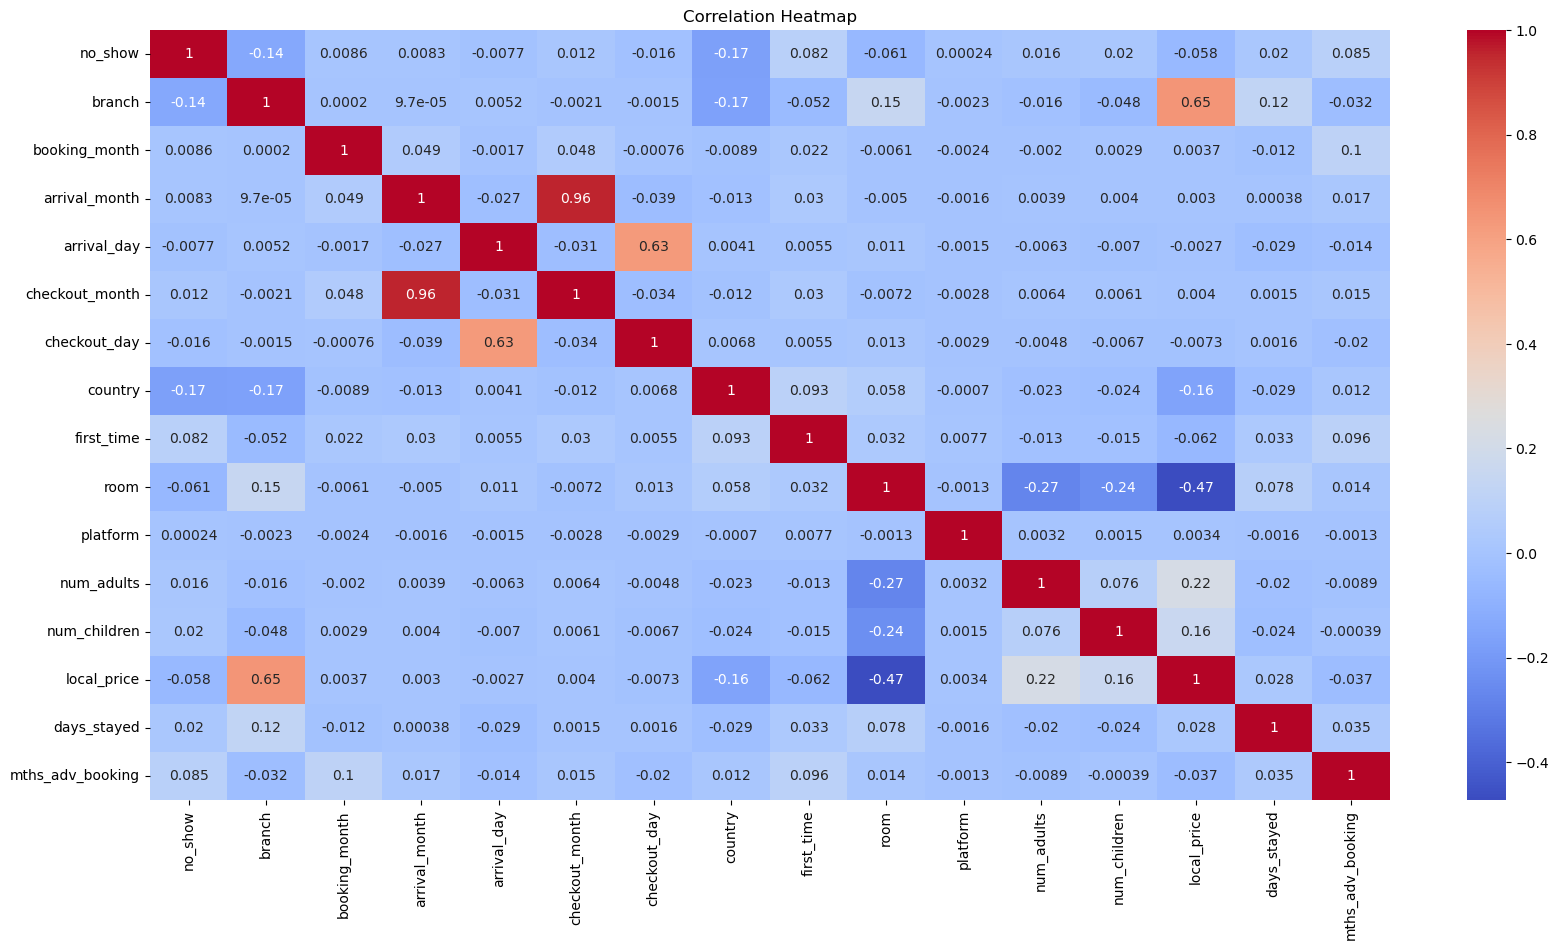

In [159]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df5.corr(), annot=True, cmap="coolwarm");
heatmap.set_title('Correlation Heatmap')
plt.show()

### Lasso Regression (Feature Selection)

In [185]:
degree = 1
lassoAlpha = 1
stepsLassoRegression = [
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('scaler', MinMaxScaler()),
    ('model', Lasso(alpha=lassoAlpha, max_iter=10000, fit_intercept=True))
]

lassoPipe = Pipeline(stepsLassoRegression)

lassoPipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('scaler', MinMaxScaler()),
                ('model', Lasso(alpha=1, max_iter=10000))])

In [201]:
degree = 1
weightsLasso = None
alpha_list = np.arange(0.0001,0.03,0.001)

for alpha in alpha_list:
    degree = 1
    lassoPipe['poly'].alpha = degree
    lassoPipe['model'].alpha = alpha
    lassoPipe['model'].max_iter=10000
    lassoPipe.fit(X_train, y_train)
    coef = lassoPipe['model'].coef_
    coef = np.insert(coef,0,alpha)
    #print(coef)
    if weightsLasso is None: 
        weightsLasso = np.array(coef).reshape(1,-1)
    else:
        weightsLasso = np.vstack((weightsLasso, coef))

In [202]:
feature_names  = list(lassoPipe['poly'].get_feature_names_out())
feature_headings = feature_names.copy()
feature_headings.insert(0,'C')
feature_headings

['C',
 'branch',
 'booking_month',
 'arrival_month',
 'arrival_day',
 'checkout_month',
 'checkout_day',
 'country',
 'first_time',
 'room',
 'platform',
 'num_adults',
 'num_children',
 'local_price',
 'days_stayed',
 'mths_adv_booking']

In [203]:
weightsLasso = pd.DataFrame(weightsLasso, columns = feature_headings)
weightsLasso

,C,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,local_price,days_stayed,mths_adv_booking
0,0.0001,-0.177039,-0.002939,-0.032304,0.00832,0.037496,-0.026352,-0.399271,0.233264,-0.025561,-0.000493,0.001249,0.000882,0.055875,0.352709,0.110353
1,0.0011,-0.156155,-0.000000,0.000000,-0.00000,0.000000,-0.009604,-0.380372,0.202111,-0.031450,-0.000000,0.000000,0.000000,0.000000,0.000000,0.103414
2,0.0021,-0.151485,-0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.360444,0.168565,-0.025204,-0.000000,0.000000,0.000000,0.000000,0.000000,0.095534
3,0.0031,-0.146833,-0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.340456,0.135123,-0.018854,-0.000000,0.000000,0.000000,0.000000,0.000000,0.087472
4,0.0041,-0.142180,0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.320469,0.101680,-0.012504,-0.000000,0.000000,0.000000,0.000000,0.000000,0.079410
5,0.0051,-0.137528,0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.300481,0.068237,-0.006154,-0.000000,0.000000,0.000000,0.000000,0.000000,0.071348
6,0.0061,-0.132852,0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.280469,0.034807,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.063290
7,0.0071,-0.127391,0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.259698,0.001783,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.055339
8,0.0081,-0.121531,0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.240852,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.045785
9,0.0091,-0.115649,0.000000,0.000000,-0.00000,0.000000,-0.000000,-0.222116,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.036139


In [204]:
feature_names 

['branch',
 'booking_month',
 'arrival_month',
 'arrival_day',
 'checkout_month',
 'checkout_day',
 'country',
 'first_time',
 'room',
 'platform',
 'num_adults',
 'num_children',
 'local_price',
 'days_stayed',
 'mths_adv_booking']

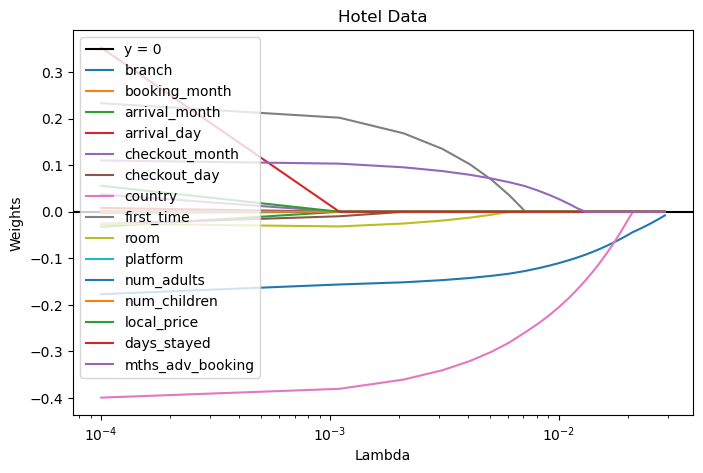

In [205]:
plt.close('all')
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 5))
ax1.axhline(y=0, c='black', label=str('y = 0'))
for f in feature_names:
    ax1.plot(weightsLasso['C'], weightsLasso[f], label=str(f))
ax1.set_title('Hotel Data')
ax1.set_xscale("log")
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Weights')
ax1.legend(loc="upper left")
plt.show()


In [208]:
weightsLasso.iloc[5]

C                   0.005100
branch             -0.137528
booking_month       0.000000
arrival_month       0.000000
arrival_day        -0.000000
checkout_month      0.000000
checkout_day       -0.000000
country            -0.300481
first_time          0.068237
room               -0.006154
platform           -0.000000
num_adults          0.000000
num_children        0.000000
local_price         0.000000
days_stayed         0.000000
mths_adv_booking    0.071348
Name: 5, dtype: float64

## Conclusion

**Base on the heat map we can conclude that first time visitor has positive impact on the target whereas country where the customer comes from and branch has reverse negative impact. The type of rooms and number of months in advance booking has some minor impact.** 

## 14. Target Balance 

In [209]:
all_y = df4['no_show']

In [210]:
all_y.value_counts()

no_show
0    75166
1    44224
Name: count, dtype: int64

In [211]:
all_y.value_counts()[1]/len(all_y)

0.37041628277075134

In [212]:
all_y.value_counts()[0]/len(all_y)

0.6295837172292487

**The data is not very imbalance. Will not do any adjustment.**

## End